## Использование библиотек для решения задач оптимизации

Первая часть лабораторной работы

In [83]:
from utils.config import *

### Задание 1.

Изучить использование PyTorch для автоматического вычисления градиента.

Для начала попробуем найти градиет простой функции $3x^2 + 2$ по значениям ее точек.
Будем использовать torch.gradient для этого.
$\nabla f = 6x. $
Достаточно передать тензор значений этой функции в gradient - мы получаем результат.

In [84]:
def f(a): 
    return 3 * torch.pow(a, 2) + 2
    
x = torch.tensor([-2., -1., 0., 1., 2., 3., 4., 5.])
fx = f(x)
print("grad:", *torch.gradient(fx, edge_order=2))

grad: tensor([-12.,  -6.,   0.,   6.,  12.,  18.,  24.,  30.])


Что же делать если у нас значения функции идут не с разницей в единицу?
Для этого есть параметр spacing 
Он позволяет как мультипликативно задать смещение, так и указать точки конкретно:

In [85]:
x = torch.tensor([-2., 0., 2.])
fx = f(x)
print("grad:", *torch.gradient(fx, spacing=2, edge_order=2))

x = torch.tensor([0., 1., 5.])
fx = f(x)
print("grad:", *torch.gradient(fx, spacing=(x,), edge_order=2))

grad: tensor([-12.,   0.,  12.])
grad: tensor([-2.3842e-07,  6.0000e+00,  3.0000e+01])


Конечно, градиент одномерной функции - скучновато, но gradient, естественно, умеет и в многомерные.
spacing для разных иземерний можно задавать туплом / тензором
Так же есть параметр dim, на случай есть нам нужна производная только по конкретным переменным

$f = x + y^2 + 2$

$\nabla f = ( 1, 2y ) $

In [86]:
fa = torch.tensor([[2., 3., 6., 11.],
                   [3., 4., 7., 12.],
                   [4., 5., 8., 13.]])
print("2d grad:", *torch.gradient(fa, edge_order=2))

print("grad for x:")
print(*torch.gradient(fa, dim=0, edge_order=2))

print("grad for y:")
print(*torch.gradient(fa, dim=1, edge_order=2))

2d grad: tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]) tensor([[0., 2., 4., 6.],
        [0., 2., 4., 6.],
        [0., 2., 4., 6.]])
grad for x:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
grad for y:
tensor([[0., 2., 4., 6.],
        [0., 2., 4., 6.],
        [0., 2., 4., 6.]])


пример вычисления градиента в точке 10:

$f = (x^2 + 16)^2$

$\nabla f = 2(x^2 + 16)(2x) = 4 x (x^2 + 16)$

$\nabla f (10) = 4 \cdot 10 \cdot (100 + 16) = 40 \cdot 116 = 4640$

Теперь применим фунцию backward.
Для этого нам понадобиться указать requires_grad=True
А после получить .grad у тензора

In [87]:
x = torch.tensor(10.0, requires_grad=True)
y = x*x + 16
z = y*y

z.backward()
x.grad # капец удобно

tensor(4640.)

пример вычисления градиента в точке (5, $\pi$/2)

$\displaystyle f(x, y) = \frac{1 + x^3}{x \cdot sin(y)}$

$\displaystyle f'_{x}(x, y) = \frac{(1 + x^3)'x \cdot sin(y) - (x \cdot sin(y))'(1 + x^3)}{x^2 \cdot sin^2(y)} = \frac{3 x^3 \cdot sin (y) - sin(y) - x^3 \cdot sin(y)}{x^2 \cdot sin^2(y)} = \frac{2x^3 - 1}{x^2 \cdot sin(y)}$

$\displaystyle f'_{y}(x, y) = -\frac{(1 + x^3) \cdot cos(y)}{x^2 \cdot sin^2(y)}$

In [88]:
def f(x, y):
    return (1 + x**3) / (x * torch.sin(y))

c = (torch.tensor(5.0, dtype=torch.float64, requires_grad=True), torch.tensor(torch.pi/2, dtype=torch.float64, requires_grad=True))
z = f(*c)
z.backward()

print("f(5, pi/2) = {}".format(z))
print("f_grad(5, pi/2) = {}".format([i.grad for i in c]))

f(5, pi/2) = 25.2
f_grad(5, pi/2) = [tensor(9.9600, dtype=torch.float64), tensor(-1.5431e-15, dtype=torch.float64)]


PyTorch предоставляет очень удобный способ подсчета производной с помощью тензоров и фукнции backward.

### Задание 2.

Изучить использование вариантов SGD (torch.optim) из PyTorch. Исследовать эффективность и сравнить с собственными релизациями из 2 работы.

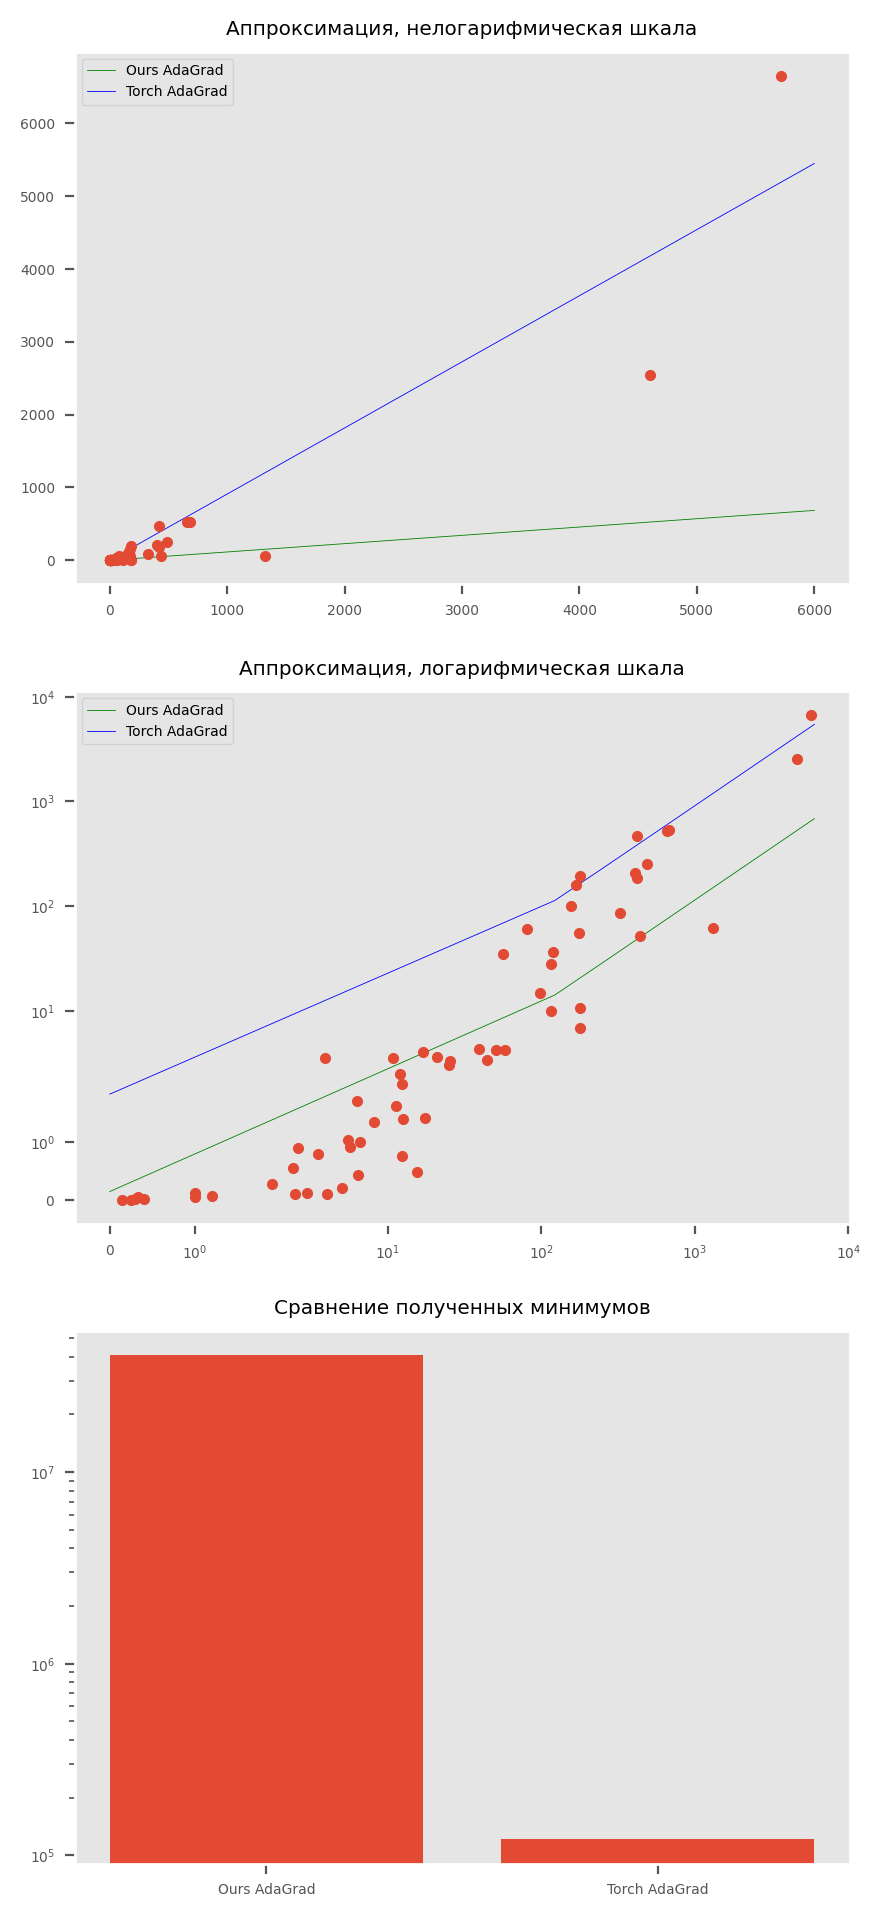

In [89]:
from utils.lab2 import *
model = torch.nn.Linear(1, 1)

def run_optim(optimizer):
    EPS = 1e-3
    MAX_STEPS = 1000
    LOSS_FUNC = torch.nn.MSELoss()
    
    pts_x, pts_y = load_points()
    pts_x = torch.tensor(pts_x)
    pts_y = torch.tensor(pts_y)
    point_pairs = load_points(False, True)
 
    loss = None
    prediction = None
    prev = 0
    cur = 1e9
    i = 0
    loader = torch.utils.data.DataLoader(point_pairs, drop_last=False)
    it = iter(loader)
    while i < MAX_STEPS and abs(prev - cur) > EPS:
        batch = None
        try:
            batch = next(it)
        except StopIteration:
            it = iter(loader)
            batch = next(it)
        x, y = batch
        x = torch.tensor([x], dtype=torch.float32)
        y = torch.tensor([y], dtype=torch.float32)
        i += 1
        optimizer.zero_grad()
        prediction = model(x)
        loss = LOSS_FUNC(prediction, y)
        loss.backward()
        optimizer.step()
        prev = cur
        cur = loss.data
    prediction = model(pts_x)
    loss = LOSS_FUNC(prediction, pts_y)
    loss.backward()
    optimizer.step()
    return loss.data, [list(model.parameters())[0].data[0, 0].item(), list(model.parameters())[1].data[0].item()]



compate_funcs((brains_and_weight_solve, (AdaGradMover(), 0.01), "Ours AdaGrad"),
              (run_optim, (torch.optim.Adagrad(model.parameters(), lr=0.1),), "Torch AdaGrad"))

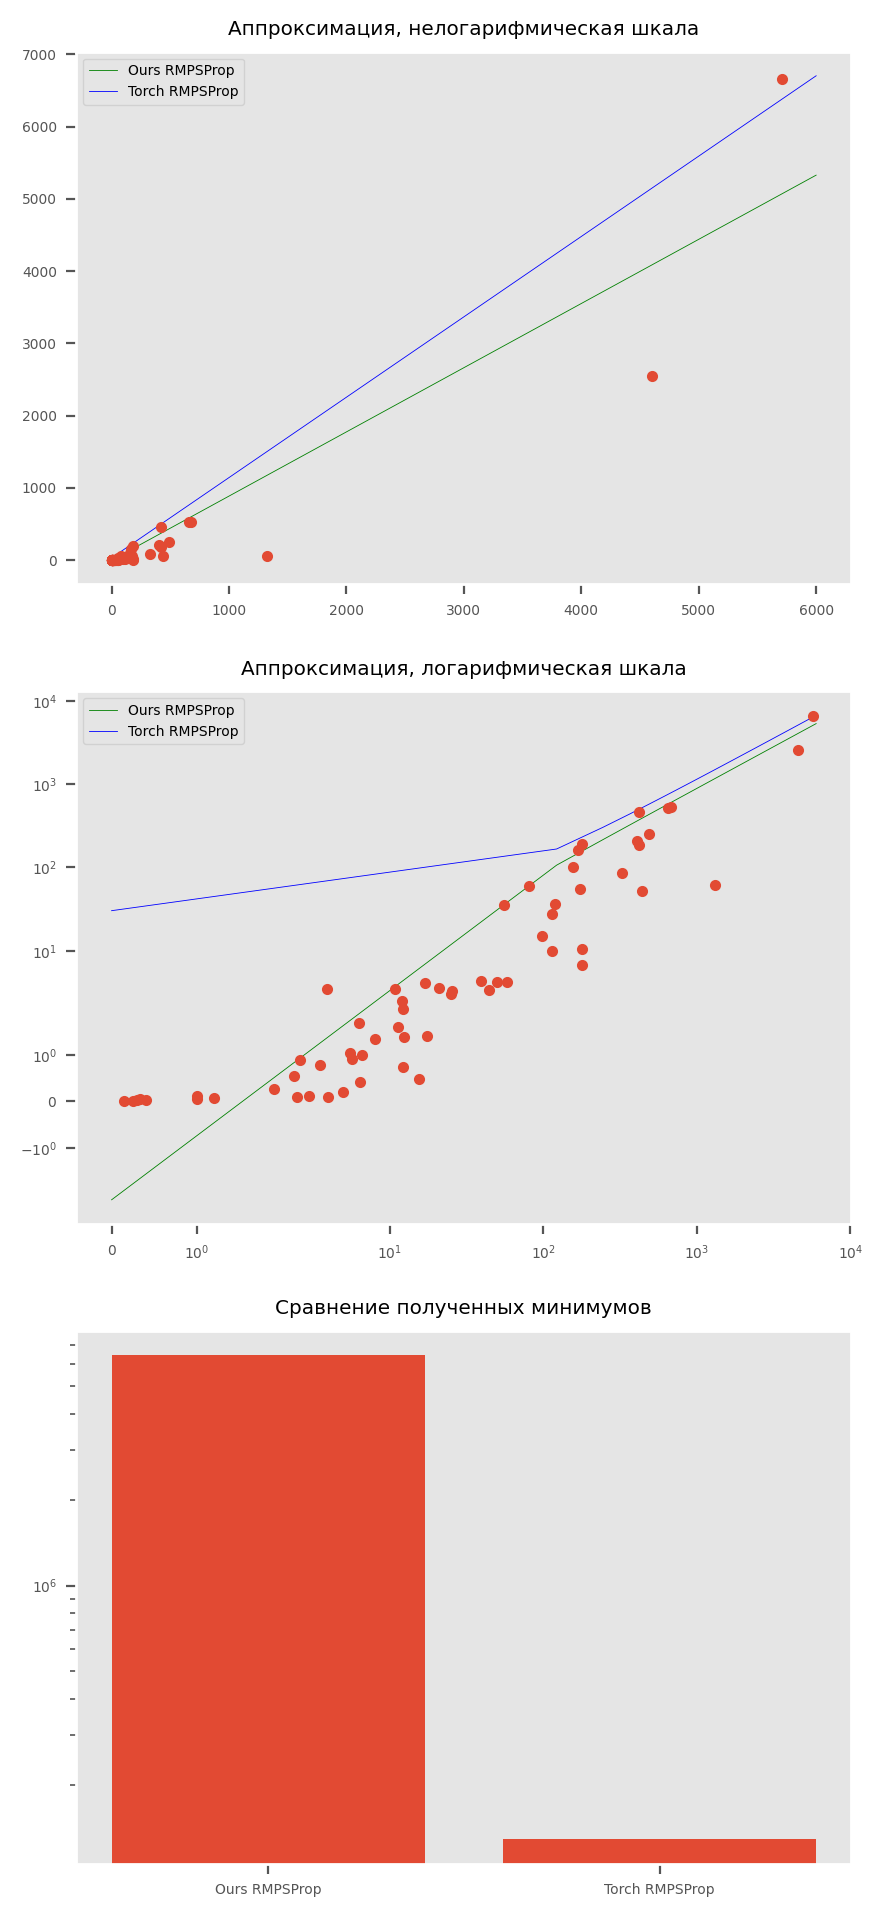

In [90]:
compate_funcs((brains_and_weight_solve, (RMSPropMover(0.9), 0.21), "Ours RMPSProp"),
              (run_optim, (torch.optim.RMSprop(model.parameters(), lr=0.21),), "Torch RMPSProp"))

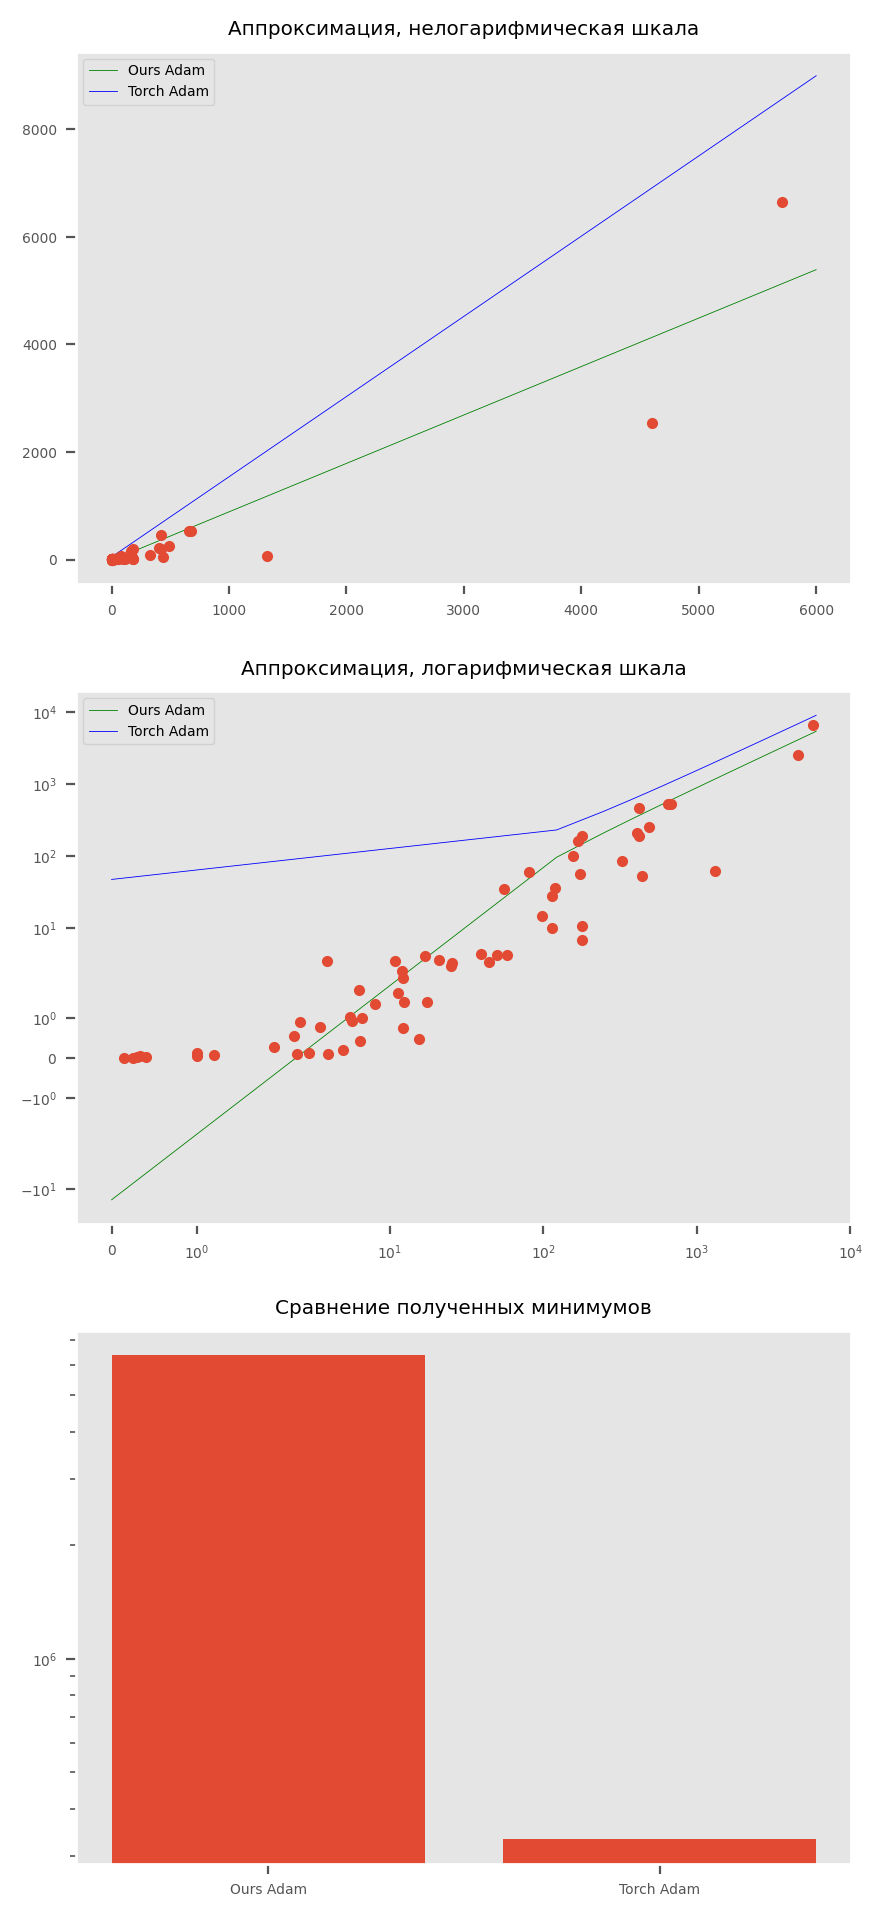

In [91]:
compate_funcs((brains_and_weight_solve, (AdamMover(0.98, 0.94), 0.14), "Ours Adam"),
              (run_optim, (torch.optim.Adam(model.parameters(), lr=0.21),), "Torch Adam"))

Вывод: PyTorch не поставляет SGD "из коробки", ожидается что пользователь сам реализует батчинг поверх реализованных алгоритмов. По эффективности эти алгоритмы смогли обойти наши реализации... возможно вмешадасб сишная машия / коэффициенты.

### Задание 3

Изучить использование готовых методов оптимизации из SciPy (scipy.optimize.minimize, scipy.optimize.least_squares)

[дока с scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

[дока с scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

### Задание 3, пункт (c)

Рассмотреть работу методов из SciPy при задании границ изменения для параметров.

In [92]:
from math import sin
def f(x):
    sum = 0
    for i in range(0, len(x)):
        sum += x[i] ** (2 * i)
    return sum * sin(x[0])

size = 4
ar = []
for i in range(size):
    ar.append(np.random.rand() * 100)
    
bounds = [(-1e9, 1e9) for _ in range(size)]
bounds[0] = (0, np.pi)
res = minimize(f, ar, method="L-BFGS-B")
print(res)
print("мы проиграли... а теперь используешь bounds")
print('\n\n\n')
res = minimize(f, ar, method="L-BFGS-B", bounds=bounds)
print(res)

      fun: -3.393745931152296e+35
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.51856329e+34,  0.00000000e+00,  0.00000000e+00, -2.43212034e+30])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 155
      nit: 8
     njev: 31
   status: 0
  success: True
        x: array([-1.10098727e+04,  6.16231207e+01,  5.13795996e+04,  8.36998000e+05])
мы проиграли... а теперь используешь bounds




      fun: 1.5129367484959893e-09
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.23540661e+07,  8.93354988e-15,  1.81886869e-11,  5.46665238e-10])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 3.14159265, 36.34903376, 33.36133964, 14.93866791])


Вывод: bounds бывают полезны, когда мы знаем "область определения" фукнции и не хотим чтобы алгоритм выходил за нее.